In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


In [3]:
idh = pd.read_csv('data/idh_estados_2021.csv', encoding='utf-8', decimal=',')
votacao = pd.read_csv('data/votacao_partido_munzona_2022_BRASIL.csv', encoding='utf-8')
vacina = pd.read_csv('data/cobertura_vacinal_municipios_2023.csv', encoding='utf-8')

## ❓Questão 1: IDH x Cobertura Vacinal

Existe relação entre IDH e cobertura vacinal dos estados? Qual?

In [4]:
vacina_estado = vacina.groupby('UF')['COBERTURA_VACINAL'].mean().reset_index()
idh_vacina = pd.merge(idh, vacina_estado, on='UF')

# Ordena o DataFrame pelo IDH para garantir a ordem crescente no eixo x
idh_vacina_sorted = idh_vacina.sort_values('IDHM2021')

fig1 = px.scatter(
    idh_vacina_sorted,
    x='IDHM2021',
    y='COBERTURA_VACINAL',
    hover_name='UF',  # Mostra o estado no hover
    labels={'IDHM2021': 'IDH (2021)', 'COBERTURA_VACINAL': 'Cobertura Vacinal (%)'},
    title='Relação entre IDH dos estados e Cobertura Vacinal da Influenza em 2023',

)

fig1.update_layout(
    xaxis=dict(categoryorder='array', categoryarray=idh_vacina_sorted['IDHM2021']),
)

fig1.show()


In [ ]:
# Filtra apenas o 1º turno
votacao_1 = votacao[votacao['NR_TURNO'] == 1]


## Questão 2: Partidos mais votados por Estado em 2022

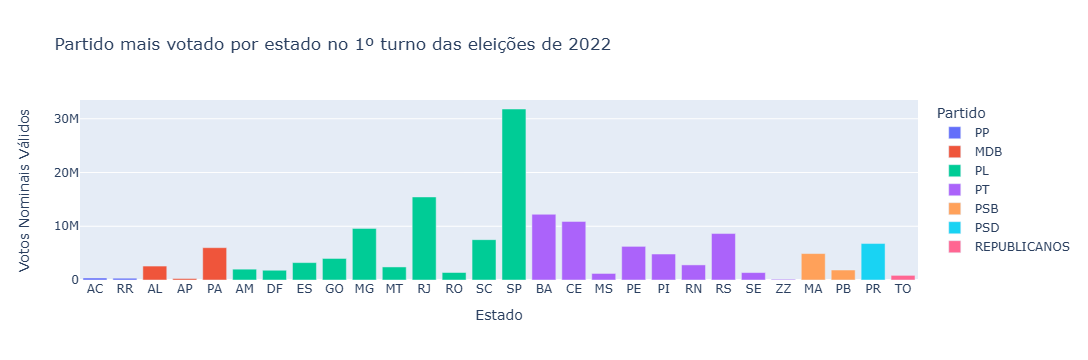

In [4]:
# 2. Partido mais votado por estado no primeiro turno 2022

# Filtrar somente o 1º turno
votacao_1t = votacao[(votacao['TURNO'] == 1)]

# Agrupar votos por estado e partido, só 1º turno e sem 'BR'
votos_estado = votacao_1t.groupby(['UF', 'SG_PARTIDO'])['QT_VOTOS_NOMINAIS_VALIDOS'].sum().reset_index()

# Selecionar partido mais votado por estado
partido_mais_votado = votos_estado.loc[votos_estado.groupby('UF')['QT_VOTOS_NOMINAIS_VALIDOS'].idxmax()]

# Criar gráfico
fig2 = px.bar(partido_mais_votado, x='UF', y='QT_VOTOS_NOMINAIS_VALIDOS', color='SG_PARTIDO',
              labels={'QT_VOTOS_NOMINAIS_VALIDOS':'Votos Nominais Válidos', 'UF':'Estado', 'SG_PARTIDO':'Partido'},
              title='Partido mais votado por estado no 1º turno das eleições de 2022')
fig2.show()

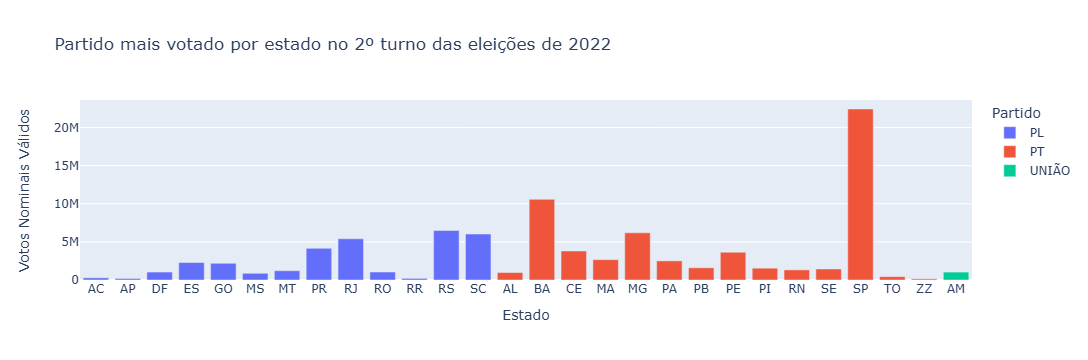

In [5]:
# 2. Partido mais votado por estado no 2o turno em 2022

# Filtrar somente o 2º turno
votacao_2t = votacao[(votacao['TURNO'] == 2)]

# Agrupar votos por estado e partido, só 1º turno e sem 'BR'
votos_estado2 = votacao_2t.groupby(['UF', 'SG_PARTIDO'])['QT_VOTOS_NOMINAIS_VALIDOS'].sum().reset_index()

# Selecionar partido mais votado por estado
partido_mais_votado2 = votos_estado2.loc[votos_estado2.groupby('UF')['QT_VOTOS_NOMINAIS_VALIDOS'].idxmax()]

# Criar gráfico
fig2 = px.bar(partido_mais_votado2, x='UF', y='QT_VOTOS_NOMINAIS_VALIDOS', color='SG_PARTIDO',
              labels={'QT_VOTOS_NOMINAIS_VALIDOS':'Votos Nominais Válidos', 'UF':'Estado', 'SG_PARTIDO':'Partido'},
              title='Partido mais votado por estado no 2º turno das eleições de 2022')
fig2.show()

## Questão 3: % Vacinal x Partido Mais Votado

In [16]:
# 1. Média de cobertura vacinal por estado
media_vacinal_estado = vacina.groupby('UF')['COBERTURA_VACINAL'].mean().reset_index()
media_vacinal_estado.rename(columns={'COBERTURA_VACINAL': 'media_cobertura_vacinal'}, inplace=True)

# 2. Filtrar 1º turno e remover BR
votacao_1t = votacao[(votacao['TURNO'] == 1)]

# 3. Partido mais votado por estado
votos_estado = votacao_1t.groupby(['UF', 'SG_PARTIDO'])['QT_VOTOS_NOMINAIS_VALIDOS'].sum().reset_index()
partido_mais_votado = votos_estado.loc[votos_estado.groupby('UF')['QT_VOTOS_NOMINAIS_VALIDOS'].idxmax()]

# 4. Mesclar os dois
dados_plot = pd.merge(media_vacinal_estado, partido_mais_votado, on='UF', how='inner')

# 5. Ordenar pelo valor da cobertura vacinal
dados_plot_sorted = dados_plot.sort_values('media_cobertura_vacinal')


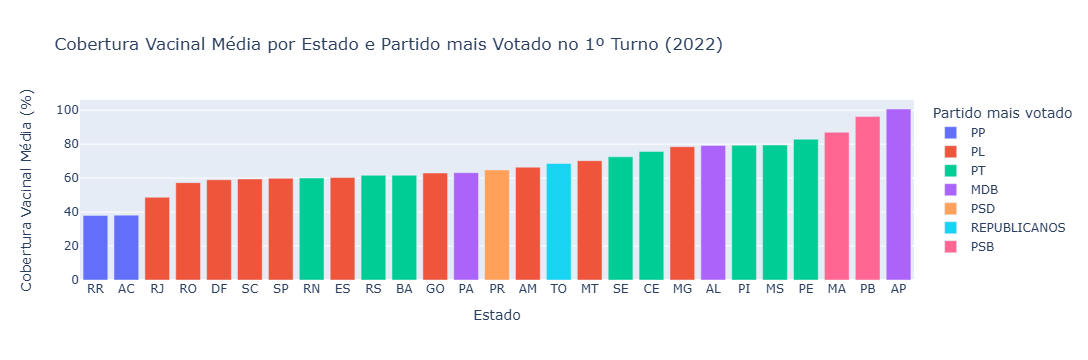

In [17]:
fig = px.bar(
    dados_plot_sorted,
    x='UF',
    y='media_cobertura_vacinal',
    color='SG_PARTIDO',
    hover_data=['QT_VOTOS_NOMINAIS_VALIDOS'],
    labels={
        'UF': 'Estado',
        'media_cobertura_vacinal': 'Cobertura Vacinal Média (%)',
        'SG_PARTIDO': 'Partido mais votado'
    },
    title='Cobertura Vacinal Média por Estado e Partido mais Votado no 1º Turno (2022)'
)

fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': dados_plot_sorted['UF']})
fig.show()

In [11]:
# 1. Média de cobertura vacinal por estado
media_vacinal_estado = vacina.groupby('UF')['COBERTURA_VACINAL'].mean().reset_index()
media_vacinal_estado.rename(columns={'COBERTURA_VACINAL': 'media_cobertura_vacinal'}, inplace=True)

# 2. Filtrar apenas 1º turno
votacao_1t = votacao[votacao['TURNO'] == 1]

# 3. Agrupar votos por estado e partido
votos_estado = votacao_1t.groupby(['UF', 'SG_PARTIDO'])['QT_VOTOS_NOMINAIS_VALIDOS'].sum().reset_index()

# 4. Obter os 3 partidos menos votados por estado
votos_estado['rank'] = votos_estado.groupby('UF')['QT_VOTOS_NOMINAIS_VALIDOS'].rank(method='first')
partidos_menos_votados = votos_estado.groupby('UF').apply(lambda x: x.nsmallest(3, 'QT_VOTOS_NOMINAIS_VALIDOS')).reset_index(drop=True)

# 5. Juntar com a média de cobertura vacinal por estado
dados_plot = pd.merge(partidos_menos_votados, media_vacinal_estado, on='UF', how='left')

# 6. Ordenar por cobertura vacinal
dados_plot_sorted = dados_plot.sort_values('media_cobertura_vacinal')

# 7. Gráfico
import plotly.express as px

fig = px.bar(
    dados_plot_sorted,
    x='UF',
    y='media_cobertura_vacinal',
    color='SG_PARTIDO',
    hover_data=['QT_VOTOS_NOMINAIS_VALIDOS'],
    labels={
        'UF': 'Estado',
        'media_cobertura_vacinal': 'Cobertura Vacinal Média (%)',
        'SG_PARTIDO': 'Partido menos votado'
    },
    title='Cobertura Vacinal Média por Estado e 3 Partidos Menos Votados no 1º Turno (2022)',
    barmode='group'  # Mostra os 3 partidos lado a lado por estado
)

fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': dados_plot_sorted['UF'].unique()})
fig.show()


C:\Users\bruno\AppData\Local\Temp\ipykernel_21020\4117029088.py:13: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



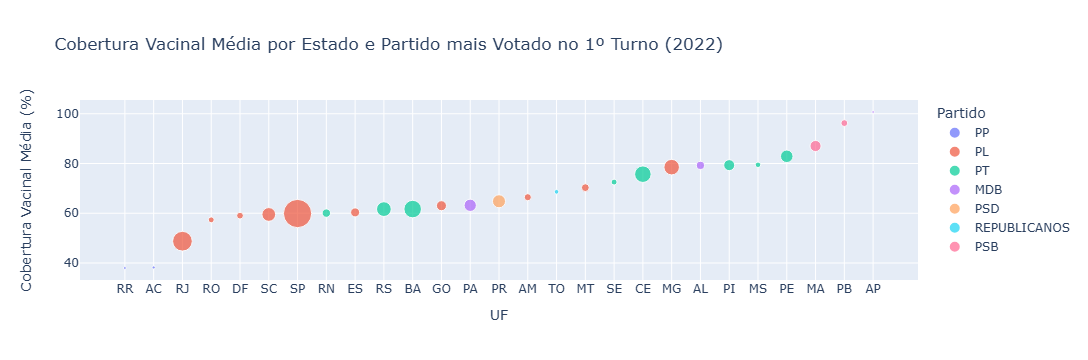

In [18]:
fig = px.scatter(
    dados_plot_sorted,
    x='UF',
    y='media_cobertura_vacinal',
    color='SG_PARTIDO',
    size='QT_VOTOS_NOMINAIS_VALIDOS',
    hover_name='UF',
    labels={
        'media_cobertura_vacinal': 'Cobertura Vacinal Média (%)',
        'QT_VOTOS_NOMINAIS_VALIDOS': 'Votos no Partido mais Votado',
        'SG_PARTIDO': 'Partido'
    },
    title='Cobertura Vacinal Média por Estado e Partido mais Votado no 1º Turno (2022)'
)

fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': dados_plot_sorted['UF']})
fig.show()


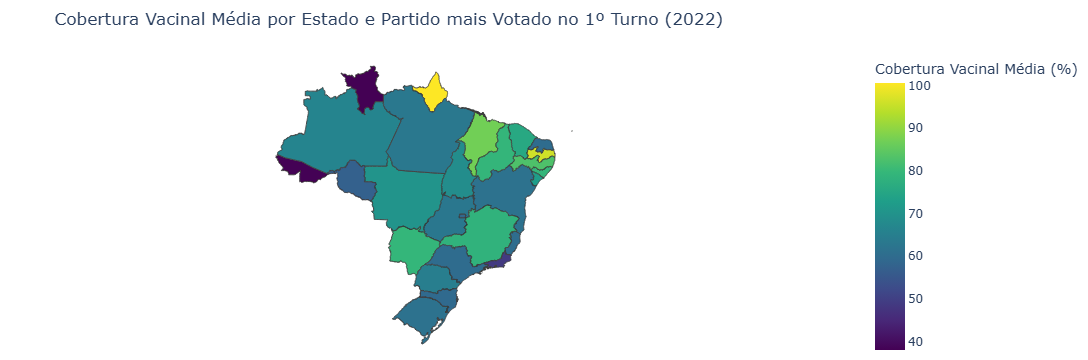

In [21]:
# 1. Calcular média de cobertura vacinal por estado
media_vacinal_estado = vacina.groupby('UF')['COBERTURA_VACINAL'].mean().reset_index()
media_vacinal_estado.rename(columns={'COBERTURA_VACINAL': 'media_cobertura_vacinal'}, inplace=True)

# 2. Filtrar apenas 1º turno e remover 'BR'
votacao_1t = votacao[(votacao['TURNO'] == 1)]

# 3. Obter o partido mais votado por estado
votos_estado = votacao_1t.groupby(['UF', 'SG_PARTIDO'])['QT_VOTOS_NOMINAIS_VALIDOS'].sum().reset_index()
partido_mais_votado = votos_estado.loc[votos_estado.groupby('UF')['QT_VOTOS_NOMINAIS_VALIDOS'].idxmax()]

# 4. Mesclar
dados_mapa = pd.merge(media_vacinal_estado, partido_mais_votado, on='UF', how='inner')

# 5. Criar mapa
fig = px.choropleth(
    dados_mapa,
    geojson="https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson",
    locations='UF',
    featureidkey="properties.sigla",  # 'sigla' ou 'UF' dependendo do GeoJSON
    color='media_cobertura_vacinal',
    color_continuous_scale="Viridis",
    hover_name='UF',
    hover_data={
        'media_cobertura_vacinal': ':.2f',
        'SG_PARTIDO': True,
        'QT_VOTOS_NOMINAIS_VALIDOS': True
    },
    labels={
        'media_cobertura_vacinal': 'Cobertura Vacinal Média (%)',
        'SG_PARTIDO': 'Partido mais votado',
        'QT_VOTOS_NOMINAIS_VALIDOS': 'Votos no Partido'
    },
    title='Cobertura Vacinal Média por Estado e Partido mais Votado no 1º Turno (2022)'
)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()
